In [1]:
import time
start = time.time()

import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
#%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable

In [2]:
mat = scipy.io.loadmat('Train_Raw_3.mat')
Train_Raw = mat['Train_Raw']
mat1 = scipy.io.loadmat('Val_Raw_3.mat')
Val_Raw = mat1['Val_Raw']

In [3]:
l,w = 45,35
Total_Train_Photo = int((Train_Raw.shape[0]*Train_Raw.shape[1])/(l*w))
Total_Val_Photo = int((Val_Raw.shape[0]*Val_Raw.shape[1])/(l*w))
Photo_Train_Col = 37
Photo_Val_Col = 37
print(Total_Train_Photo)
print(Total_Val_Photo)

1850
3700


In [4]:
#Normalisasi
Train_Raw_Norm = Train_Raw/255
Val_Raw_Norm = Val_Raw/255

In [5]:
i=0
input_data_raw = np.zeros([Total_Train_Photo,l,w])
val_data_raw = np.zeros([Total_Val_Photo,l,w])
for a in range(0,int(Total_Train_Photo/Photo_Train_Col)):
    for b in range(0,Photo_Train_Col):
        input_data_raw[i,:,:] = Train_Raw_Norm[45*a:45+45*a,35*b:35+35*b]
        i=i+1
i,a,b=0,0,0
for a in range(0,int(Total_Val_Photo/Photo_Val_Col)):
    for b in range(0,Photo_Val_Col):
        val_data_raw[i,:,:] = Val_Raw_Norm[45*a:45+45*a,35*b:35+35*b]
        i=i+1
        
print(input_data_raw.shape)
print(val_data_raw.shape)

(1850, 45, 35)
(3700, 45, 35)


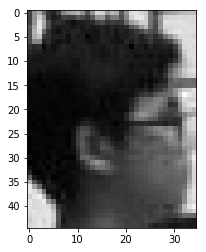

In [6]:
#plt.imshow(input_data_raw[1849,:,:], cmap='gray', vmin=0, vmax=1)

In [7]:
tar = np.eye(10)
target_train = np.zeros([Total_Train_Photo,10])
target_val = np.zeros([Total_Val_Photo,10])
for d in range(0,10):    
    target_train[0+int(Total_Train_Photo/10)*d:int(Total_Train_Photo/10)+int(Total_Train_Photo/10)*d,:] = tar[d,:]
d=0
for d in range(0,10):
    target_val[0+int(Total_Val_Photo/10)*d:int(Total_Val_Photo/10)+int(Total_Val_Photo/10)*d,:] = tar[d,:]
print(target_train.shape)
print(target_val.shape)

(1850, 10)
(3700, 10)


In [8]:
tebal_train, tebal_val = Total_Train_Photo, Total_Val_Photo
target_train3d = np.zeros(shape=(tebal_train, 1, 10))
target_val3d = np.zeros(shape=(tebal_val, 1, 10))
i=0

for i in range(tebal_train):
    target_train3d[i,0,:] = target_train[i,:]
for i in range(tebal_val):
    target_val3d[i,0,:] = target_val[i,:]

In [9]:
def train_in4d(data):
    image_size = [45,35]
    data4d = np.zeros([Total_Train_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

def val_inl4d(data):
    image_size = [45,35]
    data4d = np.zeros([Total_Val_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

def train_tar4d(data):
    image_size = [1,10]
    data4d = np.zeros([Total_Train_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

def val_tarl4d(data):
    image_size = [1,10]
    data4d = np.zeros([Total_Val_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

In [10]:
input_train4d = train_in4d(input_data_raw)
input_val4d = val_inl4d(val_data_raw)

target_train4d = train_tar4d(target_train3d)
target_val4d = val_tarl4d(target_val3d)

print(input_train4d.shape)
print(input_val4d.shape)
print(target_train4d.shape)
print(target_val4d.shape)

(1850, 1, 45, 35)
(3700, 1, 45, 35)
(1850, 1, 1, 10)
(3700, 1, 1, 10)


In [11]:
device = torch.device('cuda:0')

epoch_max = 12000
learning_rate = 0.2
batch_size_train = int(Total_Train_Photo/10)
batch_size_val = int(Total_Val_Photo/10)

In [12]:
input_train4d = torch.from_numpy(input_train4d).float().cuda()
target_train4d = torch.from_numpy(target_train4d).float().cuda()
input_val4d = torch.from_numpy(input_val4d).float().cuda()
target_val4d = torch.from_numpy(target_val4d).float().cuda()

target_train = torch.from_numpy(target_train).float().cuda()
target_val = torch.from_numpy(target_val).float().cuda()

dataset_train = torch.utils.data.TensorDataset(input_train4d, target_train)
dataset_val = torch.utils.data.TensorDataset(input_val4d, target_val)

kwargs = {}
train_loader = torch.utils.data.DataLoader(dataset_train,
                                           batch_size=batch_size_train, 
                                           shuffle=True,**kwargs)
val_loader = torch.utils.data.DataLoader(dataset_val,
                                         batch_size=batch_size_val, 
                                         shuffle=True,**kwargs)

print('There are {} images in the training set'.format(len(dataset_train)))
print('There are {} images in the test set'.format(len(dataset_val)))
print('There are {} batches in the train loader'.format(len(train_loader)))
print('There are {} batches in the testloader'.format(len(val_loader)))

There are 1850 images in the training set
There are 3700 images in the test set
There are 10 batches in the train loader
There are 10 batches in the testloader


In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 40, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1))
        self.fc1 = nn.Linear(32 * 22 * 40, 1000)
#         self.drop_out = nn.Dropout()
        self.act1 = nn.Tanh()
    
        self.fc2 = nn.Linear(1000, 500)
        self.act2 = nn.Tanh()
        
        self.fc3 = nn.Linear(500,10)
        self.act3 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
#         out = self.drop_out(out)
        out = out.view(-1, 32 * 22 * 40)
        out = self.act1(self.fc1(out))
#         out = self.fc1(out)
        out = self.act2(self.fc2(out))
        out = self.act3(self.fc3(out))
#         out = self.fc3(out)
        return out

In [14]:
model = ConvNet()
model = model.cuda()    
loss_fn = torch.nn.MSELoss(size_average='false').cuda()        
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.3)
print(model)
for p in model.parameters():
    print(p.size())

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): AvgPool2d(kernel_size=5, stride=1, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=27550, out_features=1000, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=500, out_features=10, bias=True)
  (act3): Sigmoid()
)
torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([50, 20, 5, 5])
torch.Size([50])
torch.Size([1000, 27550])
torch.Size([1000])
torch.Size([500, 1000])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


c:\users\lab-kendali\appdata\local\programs\python\python37\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [15]:
#Training dan Validasi CNN
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
#Train

for epoch in range(epoch_max):
    benar = 0
    salah = 0
    iter_loss = 0.0
    iterations = 0
    model.train()
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = Variable(inputs)
        labels = Variable(labels)
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss = iter_loss+loss.item()
        loss.backward()
        optimizer.step()
        outputs_recog = torch.round(outputs)
        labels_recog = torch.round(labels)
        for hitung in range(batch_size_train):
            if torch.equal(outputs_recog[hitung,:], labels_recog[hitung,:]):
                benar = benar + 1
            else:
                salah = salah + 1
        iterations = iterations + 1
                    
    recognition_rate = (benar/Total_Train_Photo)*100
    train_accuracy.append(recognition_rate)
    train_loss.append(iter_loss)
    
    if (epoch+1)%1000 == 0:
        torch.save(model.state_dict(),'CNN_3DFaceRecog_Save_3070_Row_v7.pth')
    
#Validasi 
    if (epoch+1)%100 == 0:
        loss_iter_val = 0.0
        benar_val = 0
        salah_val = 0
        iterations = 0

        model.eval()

        for i, (inputs, labels) in enumerate(val_loader):
            inputs = Variable(inputs)
            labels = Variable(labels)
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            loss_v = loss_fn(outputs, labels)
            loss_iter_val = loss_iter_val+loss_v.item()
            outputs_recog = torch.round(outputs)
            labels_recog = torch.round(labels)
            for hitung in range(batch_size_val):
                if torch.equal(outputs_recog[hitung,:], labels_recog[hitung,:]):
                    benar_val = benar_val + 1
                else:
                    salah_val = salah_val + 1
            iterations = iterations + 1

        recognition_rate_v = (benar_val/Total_Val_Photo)*100
        val_accuracy.append(recognition_rate_v)
        val_loss.append(loss_iter_val)
    
    print ('Epoch {}/{}, Training Loss: {:.7f}, Training Acc: {:.3f}'.
           format(epoch+1, epoch_max, 
                  train_loss[-1], 
                  train_accuracy[-1])); 
    if (epoch+1)%100 == 0:
        print('\nValidation || Validation Loss: {:.7f}, Validation Acc: {:.3f}\n'
              .format(val_loss[-1],
                     val_accuracy[-1]))

Epoch 1/20, Training Loss: 1.3832227, Training Acc: 0.000
Epoch 2/20, Training Loss: 0.9028774, Training Acc: 0.000
Epoch 3/20, Training Loss: 0.8993425, Training Acc: 0.000
Epoch 4/20, Training Loss: 0.8972290, Training Acc: 0.000
Epoch 5/20, Training Loss: 0.8948062, Training Acc: 0.000
Epoch 6/20, Training Loss: 0.8923416, Training Acc: 0.000
Epoch 7/20, Training Loss: 0.8895966, Training Acc: 0.000
Epoch 8/20, Training Loss: 0.8863592, Training Acc: 0.000
Epoch 9/20, Training Loss: 0.8828972, Training Acc: 0.000
Epoch 10/20, Training Loss: 0.8791793, Training Acc: 0.000

Validation || Validation Loss: 0.8777079, Validation Acc: 0.000

Epoch 11/20, Training Loss: 0.8752670, Training Acc: 0.000
Epoch 12/20, Training Loss: 0.8705613, Training Acc: 0.000
Epoch 13/20, Training Loss: 0.8661313, Training Acc: 0.000
Epoch 14/20, Training Loss: 0.8617285, Training Acc: 0.000
Epoch 15/20, Training Loss: 0.8574025, Training Acc: 0.000
Epoch 16/20, Training Loss: 0.8537293, Training Acc: 0.000

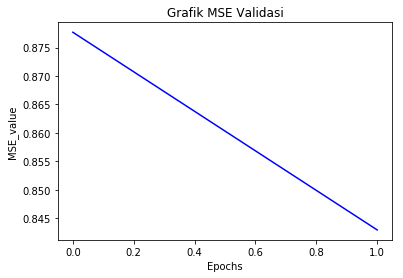

Last epoch validation loss: 0.8429224416613579


In [16]:
plt.plot(train_loss, 'b') # 'r' is the color red
plt.xlabel('Epochs')
plt.ylabel('Loss_value')
plt.title('Loss Graph Training')
plt.show()
print('Last epoch training loss: {}' .format(train_loss[-1]))

In [17]:
torch.save(model.state_dict(),'CNN_3DFaceRecog_Save_3070_Row_v7.pth')

In [18]:
print('CNN_3DFaceRecognition_v7_3070_Row_TV')
print('Epochs: {}, Training Loss: {:.7f}, Training Acc: {:.3f}, Validation Loss: {:.7f}, Validation Acc: {:.3f}'
           .format(epoch+1,
                   train_loss[-1],
                   train_accuracy[-1],
                   val_loss[-1],
                   val_accuracy[-1]))
end = time.time()

elapsed = end - start
print('Elapased Time: ', time.strftime("%H:%M:%S", time.gmtime(elapsed)))

CNN_3DFaceRecognition_v4_3070_Row_TV
Epochs: 20, Training Loss: 0.8411737, Training Acc: 2.108, Validation Loss: 0.8429224, Validation Acc: 2.243
Elapased Time:  00:00:23


In [19]:
scipy.io.savemat('Epochs_and_time_3070R_v7.mat', {'Epochs':epoch, 'time':elapsed, 'train_loss':train_loss, 'train_accuracy':train_accuracy})